In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [24]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 487.6 kB/s eta 0:05:08
   ---------------------------------------- 0.0/150.0 MB 487.6 kB/s eta 0:05:08
   ---------------------------------------- 0.1/150.0 MB 416.7 kB/s eta 0:06:00
   ---------------------------------------- 0.2/150.0 MB 701.4 kB/s eta 0:03:34
   ---------------------------------------- 0.3/150.0 MB 1.2 MB/s eta 0:02:06
   ---------------------------------------- 0.6/150.0 MB 1.9 MB/s eta 0:01:20
   ---------------------------------------- 0.8/150.0 MB 2.2 MB/s eta 0:01:08
   ---------------------------------------- 1.1/150.0 MB 2.5 MB/s eta 0:00:59
   ------------------

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRFRegressor

In [6]:
premium=pd.read_csv("Medicalpremium.csv")

In [7]:
premium.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [8]:
premium.tail()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000
985,21,0,0,0,0,158,75,1,0,1,15000


In [9]:
premium.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

In [10]:
# renaming columns for easier reference
premium = premium.rename(columns={"BloodPressureProblems":"BPProblems", "AnyTransplants":"Transplants", "AnyChronicDiseases":"Diseases", "KnownAllergies":"Allergies", "HistoryOfCancerInFamily":"CancerFHx", "NumberOfMajorSurgeries":"Surgeries", "PremiumPrice":"Premium"})
premium

,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


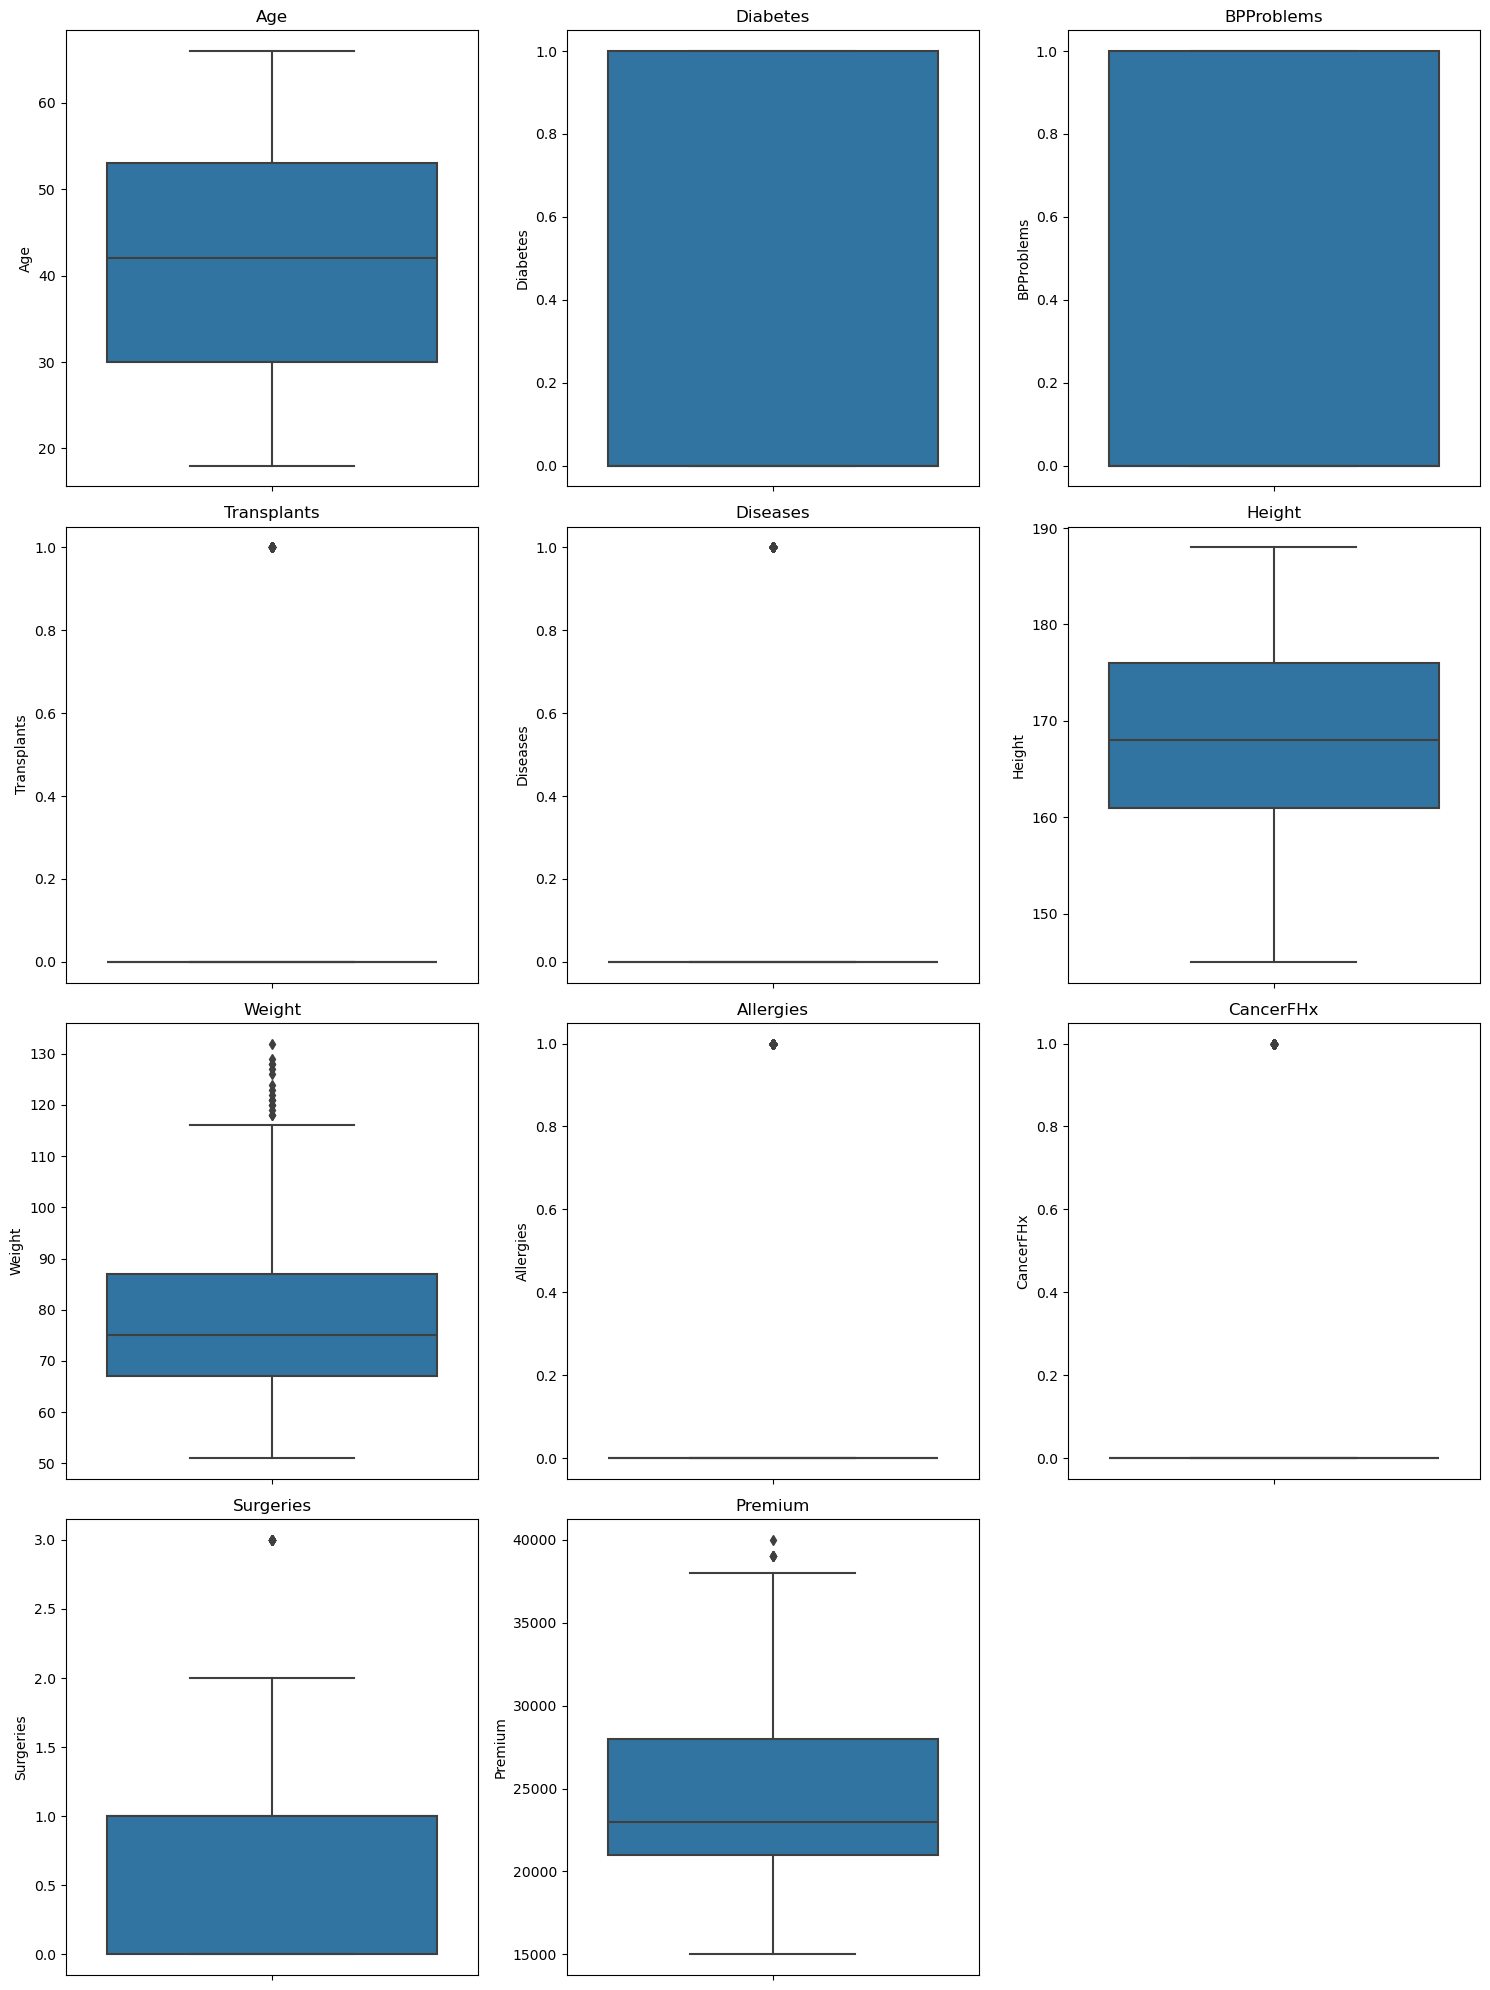

In [11]:
# Select numeric columns
numeric_cols = premium.select_dtypes(include=['int64', 'float64']).columns

# Set up subplots
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(15, 5 * ((num_cols // 3) + 1)))

axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=premium[col], ax=axes[i])
    axes[i].set_title(col)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# adding index column to track rows removed
new_data = premium.copy()
new_data['index'] = range(len(new_data))

In [13]:
new_data

,Age,Diabetes,BPProblems,Transplants,Diseases,Height,Weight,Allergies,CancerFHx,Surgeries,Premium,index
0,45,0,0,0,0,155,57,0,0,0,25000,0
1,60,1,0,0,0,180,73,0,0,0,29000,1
2,36,1,1,0,0,158,59,0,0,1,23000,2
3,52,1,1,0,1,183,93,0,0,2,28000,3
4,38,0,0,0,1,166,88,0,0,1,23000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000,981
982,64,1,1,0,0,153,70,0,0,3,28000,982
983,56,0,1,0,0,155,71,0,0,1,29000,983
984,47,1,1,0,0,158,73,1,0,1,39000,984


In [14]:
# separating binary variables from continuous variables
# This code is separating categorical (binary) variables from continuous (numeric) variables in a dataset.
bi_data = new_data.loc[:, ['index', 'Diabetes', 'BPProblems', 'Transplants', 'Diseases', 'Allergies', 'CancerFHx']]
bi_data.head()

,index,Diabetes,BPProblems,Transplants,Diseases,Allergies,CancerFHx
0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0
2,2,1,1,0,0,0,0
3,3,1,1,0,1,0,0
4,4,0,0,0,1,0,0


In [15]:
# dropping binary data columns to use for removing outliers
new_data = new_data.drop(['Diabetes', 'BPProblems', 'Transplants', 'Diseases', 'Allergies', 'CancerFHx'], axis=1)
new_data.head()

,Age,Height,Weight,Surgeries,Premium,index
0,45,155,57,0,25000,0
1,60,180,73,0,29000,1
2,36,158,59,1,23000,2
3,52,183,93,2,28000,3
4,38,166,88,1,23000,4


In [16]:
# removing outliers using IQR
Q1 = new_data.quantile(0.25)
Q3 = new_data.quantile(0.75)
IQR = Q3 - Q1

new_data = new_data[~((new_data < (Q1 - 1.5 * IQR)) | (new_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# confirming outliers removed
new_data.describe()

,Age,Height,Weight,Surgeries,Premium,index
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,41.478398,168.208641,76.146470,0.626976,24185.458377,495.123288
std,13.701797,10.143105,13.028719,0.691990,6160.764594,283.023240
min,18.000000,145.000000,51.000000,0.000000,15000.000000,0.000000
25%,30.000000,161.000000,67.000000,0.000000,21000.000000,256.000000
50%,42.000000,168.000000,75.000000,1.000000,23000.000000,500.000000
75%,52.000000,176.000000,86.000000,1.000000,28000.000000,738.000000
max,66.000000,188.000000,116.000000,2.000000,38000.000000,985.000000


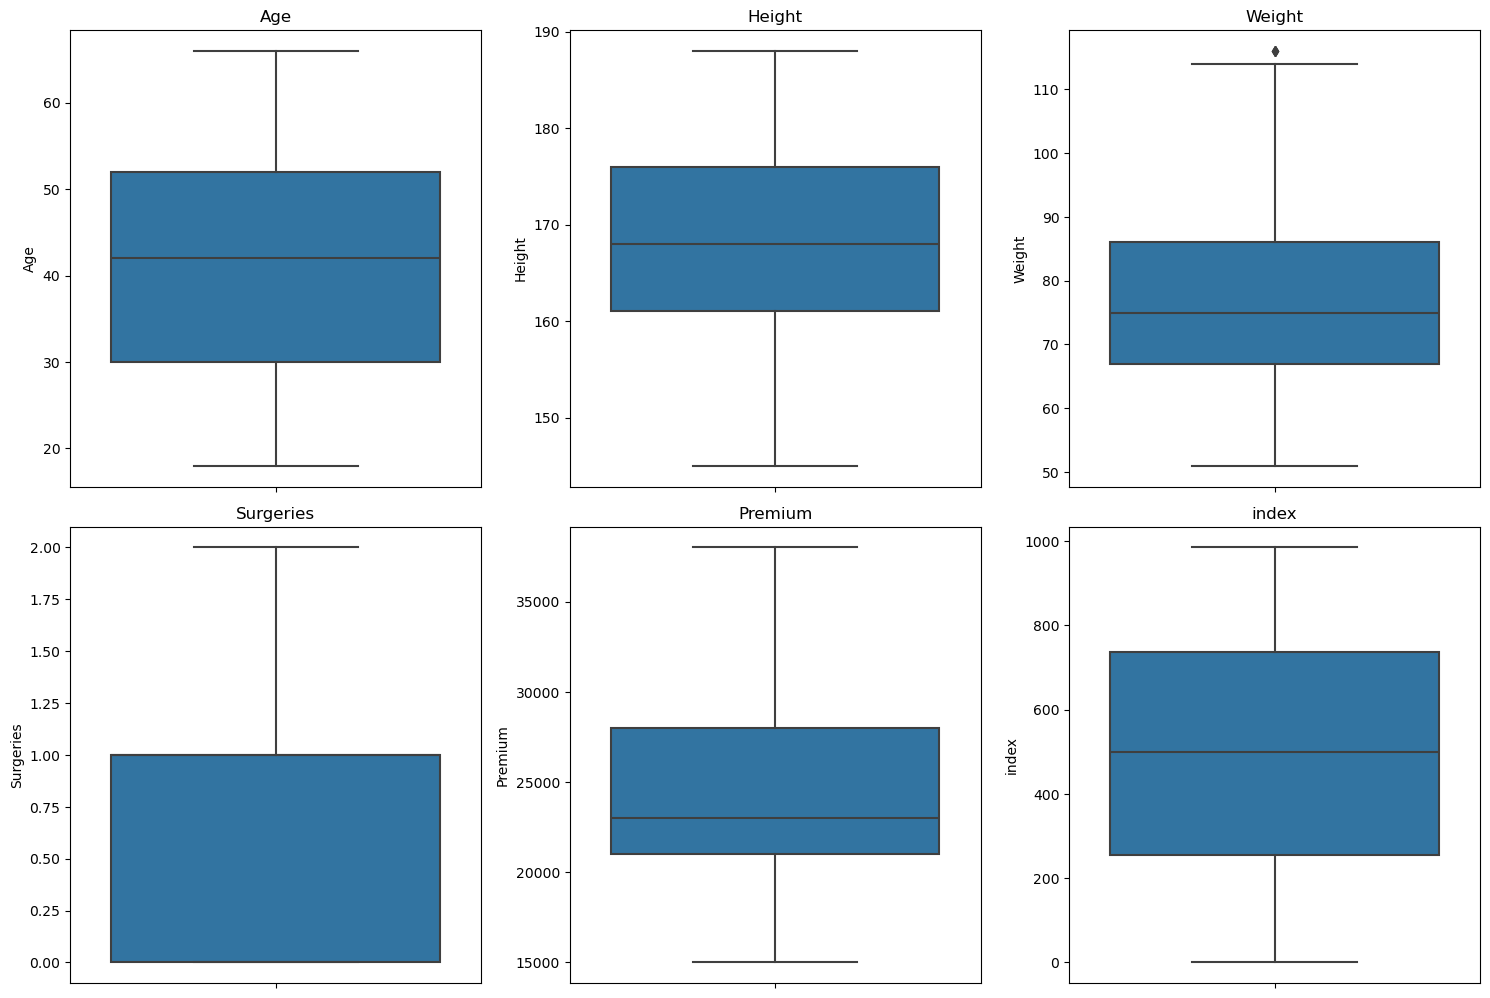

In [17]:
# Select numeric columns
numeric_cols = new_data.select_dtypes(include=['int64', 'float64']).columns

# Set up subplots
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(15, 5 * ((num_cols // 3) + 1)))

axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=new_data[col], ax=axes[i])
    axes[i].set_title(col)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
# concatenating the dataframes with inner join along index column to remove outlier rows from bi_data
df = pd.concat([new_data, bi_data], axis=1, join='inner')

# dropping index column
df = df.drop(['index'], axis=1)
df.describe()

,Age,Height,Weight,Surgeries,Premium,Diabetes,BPProblems,Transplants,Diseases,Allergies,CancerFHx
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,41.478398,168.208641,76.146470,0.626976,24185.458377,0.415174,0.469968,0.055848,0.185458,0.218124,0.119073
std,13.701797,10.143105,13.028719,0.691990,6160.764594,0.493012,0.499360,0.229750,0.388874,0.413190,0.324045
min,18.000000,145.000000,51.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,161.000000,67.000000,0.000000,21000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,168.000000,75.000000,1.000000,23000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,176.000000,86.000000,1.000000,28000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,66.000000,188.000000,116.000000,2.000000,38000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


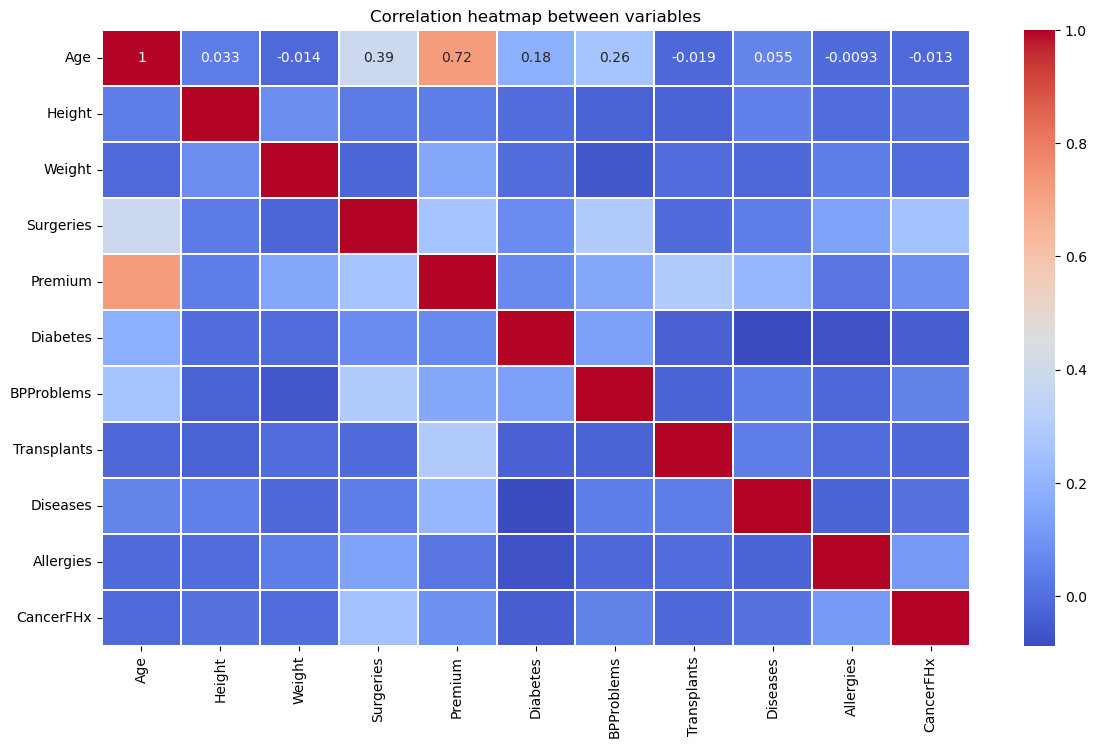

<Figure size 1600x1200 with 0 Axes>

In [21]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.1)
plt.title("Correlation heatmap between variables")
plt.figure(figsize=(16,12))
plt.show()

In [26]:
# set features and prediction target
X = df.drop('Premium', axis=1)
y = df['Premium']

# split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
models = { LinearRegression():'Linear Regression', Lasso():'Lasso', Ridge():'Ridge', XGBRFRegressor():'XGBoost Regressor', RandomForestRegressor():'Random Forest'}

# fitting data for each model
for m in models.keys():
    m.fit(X_train, y_train)
    
# printing accuracy score for each model
for model, name in models.items():
    score = model.score(X_test, y_test)*100
    print(f"{name} accuracy: ", score, "%")

Linear Regression accuracy:  65.68982111098293 %
Lasso accuracy:  65.70028390988158 %
Ridge accuracy:  65.61546775042977 %
XGBoost Regressor accuracy:  74.17703684517701 %
Random Forest accuracy:  74.41022871475349 %


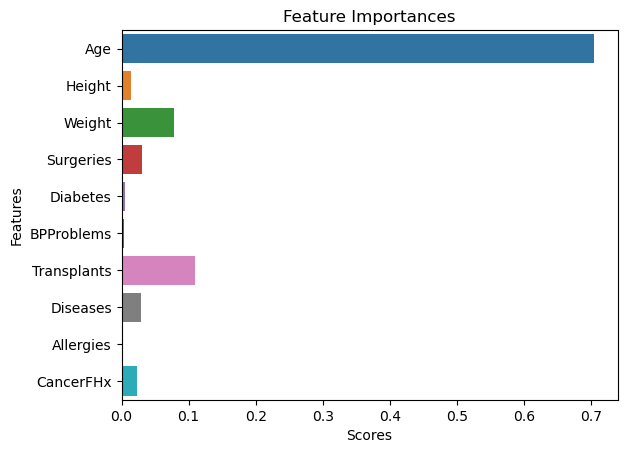

In [28]:
rand_forest = RandomForestRegressor()
rand_forest.fit(X_train, y_train)
rf_feat_import = rand_forest.feature_importances_

# graphing feature importances
sns.barplot(x=rf_feat_import, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()

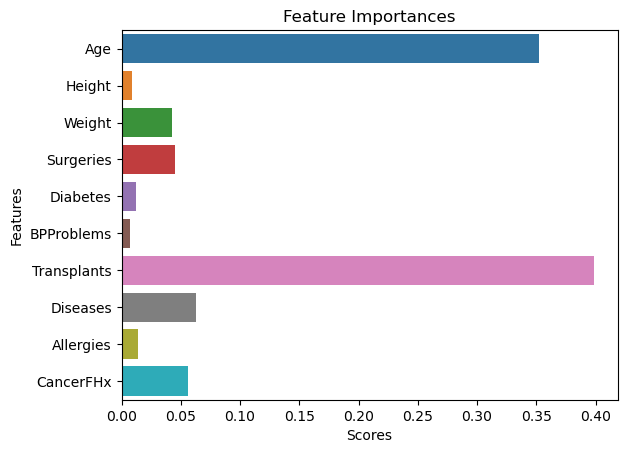

In [29]:
xgb = XGBRFRegressor()
xgb.fit(X_train, y_train)
xgb_feat = xgb.feature_importances_
sns.barplot(x=xgb_feat, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Scores')
plt.ylabel('Features')
plt.show()